In [214]:
import numpy as np
import pandas as pd 
import re
import matplotlib.pyplot as plt 
import seaborn as sns
import joblib 
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import sklearn.metrics as mt
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import (
    export_graphviz,
    DecisionTreeClassifier,
    DecisionTreeRegressor
    )
    ## check


from sklearn.ensemble import(
    RandomForestClassifier, ## check
    VotingClassifier,
    GradientBoostingClassifier,
    RandomForestRegressor
    )
from sklearn.metrics import(
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay, 
    recall_score,
    precision_score,
    mean_squared_error,
    mean_absolute_error,
    r2_score
    )     ##check
from sklearn.model_selection import (
    train_test_split,
    KFold ,
    StratifiedShuffleSplit,  ## check
    cross_val_score,     ##check
    RandomizedSearchCV
    )


In [243]:
 # 1. daily raw data 가져오기
df = pd.read_excel(r"C:\Users\siim2\sic_project_final\data\auto_raw_20_60_1.xlsx", sheet_name="Sheet1", header=0, index_col=0)


In [238]:
df.head(5)

,forward_stage,원/달러 환율,원/엔 환율,국채 3년물,국채 10년물,PER,PBR,VKOSPI,treasury_10_3_diff,T10Y2Y,...,us_e_infla_60,yield_gap(%)_60,cpi_60,export_60,WTI_60,DGS2_60,DGS10_60,TIPS_60,VIX_60,PPI_60
base_date,,,,,,,,,,,,,,,,,,,,,
2010-03-31,up,1131.3,1213.45,3.895,4.94,24.35,1.36,13.47,1.06,2.82,...,-0.001520,0.041108,0.001143,-0.003024,0.000843,0.001338,0.000067,0.002583,-0.003504,0.000217
2010-04-01,up,1126.4,1204.45,3.895,4.92,24.13,1.38,13.63,1.07,2.84,...,-0.001448,0.038560,0.000667,-0.003721,0.001020,0.001886,0.000202,0.002811,-0.003742,0.000212
2010-04-05,up,1123.1,1188.97,3.840,4.95,24.22,1.38,13.56,1.11,2.83,...,-0.001381,0.036369,0.000195,-0.004392,0.001237,0.002512,0.000351,0.003084,-0.004067,0.000207
2010-04-06,up,1123.2,1195.40,3.845,4.94,24.24,1.38,14.75,1.10,2.84,...,-0.001299,0.033592,-0.000272,-0.005038,0.001483,0.003055,0.000521,0.003383,-0.004470,0.000200
2010-04-07,up,1120.5,1191.13,3.820,4.88,24.26,1.39,14.22,1.06,2.83,...,-0.001157,0.031333,-0.000736,-0.005658,0.001698,0.003488,0.000649,0.003483,-0.004842,0.000193


In [217]:
column_names = [
    'auto',    
    # 'KOSPI Index',
    'Exchange Rate (KRW/USD)', 'Exchange Rate (KRW/JPY)',
    '3-Year Treasury Bond', '10-Year Treasury Bond', 'Price-to-Earnings Ratio', 
    'Price-to-Book Ratio', 'Volatility Index of KOSPI',
    '10-Year Treasury Bond Minus 3-Year Treasury Bond',
    '10-Year Treasury Yield Minus 2-Year Treasury Yield', 'USA Consumer Price Index', 
    'USA Employment Inflation', 'Yield Gap Percentage', 'Consumer Price Index', 
    'Export', 'West Texas Intermediate (WTI) Crude Oil Price', 
    '2-Year Treasury Constant Maturity Rate', '10-Year Treasury Constant Maturity Rate',
    'Treasury Inflation-Protected Securities (TIPS) Yield', 'Volatility Index (VIX)', 
    'Producer Price Index (PPI)', 'USA Vehicle Sales', 'Copper Futures',
    'China Fixed Asset Investment (Year-over-Year)', 
    'China Purchasing Managers\' Index (PMI)', 'Gold Futures', 
    'MSCI Emerging Markets Index', 'US Dollar Index', 'China Retail Sales',
    'China Industrial Production', 
    # 'KOSPI Index (20-day Moving Average)', 
    'Exchange Rate (KRW/USD) (20-day Moving Average)',
    'Exchange Rate (KRW/JPY) (20-day Moving Average)', 
    '3-Year Treasury Bond (20-day Moving Average)', 
    '10-Year Treasury Bond (20-day Moving Average)', 
    'Price-to-Earnings Ratio (20-day Moving Average)', 
    'Price-to-Book Ratio (20-day Moving Average)', 
    'Volatility Index of KOSPI (20-day Moving Average)',
    '10-Year Treasury Bond Minus 3-Year Treasury Bond (20-day Moving Average)', 
    '10-Year Treasury Yield Minus 2-Year Treasury Yield (20-day Moving Average)',
    'T10Y2Y_20', 'usa_cpi_20', 'us_e_infla_20', 'yield_gap(%)_20', 'cpi_20',
    'export_20', 'WTI_20', 'DGS2_20', 'DGS10_20', 'TIPS_20', 'VIX_20', 'PPI_20',
    'USA_Vehi_Sell_20', 'Copper Futures (20-day Moving Average)', 'China Fixed Asset Investment (Year-over-Year) (20-day Moving Average)',
    'China Purchasing Managers\' Index (PMI) (20-day Moving Average)', 'Gold Futures (20-day Moving Average)',
    'MSCI Emerging Markets Index (20-day Moving Average)', 'US Dollar Index (20-day Moving Average)',
    'China Retail Sales (20-day Moving Average)', 'China Industrial Production (20-day Moving Average)',
    # 'KOSPI Index (60-day Moving Average)', 
    'Exchange Rate (KRW/USD) (60-day Moving Average)',
    'Exchange Rate (KRW/JPY) (60-day Moving Average)', '3-Year Treasury Bond (60-day Moving Average)',
    '10-Year Treasury Bond (60-day Moving Average)', 'Price-to-Earnings Ratio (60-day Moving Average)',
    'Price-to-Book Ratio (60-day Moving Average)', 'VKOSPI (60-day Moving Average)',
    'Treasury 10-Year Minus 3-Year Differential (60-day Moving Average)',
    '10-Year Treasury Yield Minus 2-Year Treasury Yield (60-day Moving Average)',
    'USA Consumer Price Index (60-day Moving Average)', 'USA Employment Inflation (60-day Moving Average)',
    'Yield Gap Percentage (60-day Moving Average)', 'Consumer Price Index (60-day Moving Average)',
    'Export (60-day Moving Average)', 'West Texas Intermediate (WTI) Crude Oil Price (60-day Moving Average)',
    '2-Year Treasury Constant Maturity Rate (60-day Moving Average)',
    '10-Year Treasury Constant Maturity Rate (60-day Moving Average)',
    'Treasury Inflation-Protected Securities (TIPS) Yield (60-day Moving Average)',
    'Volatility Index (VIX) (60-day Moving Average)', 'Producer Price Index (PPI) (60-day Moving Average)',
    'USA Vehicle Sales (60-day Moving Average)', 'Copper Futures (60-day Moving Average)',
    'China Fixed Asset Investment (Year-over-Year) (60-day Moving Average)',
    'China Purchasing Managers\' Index (PMI) (60-day Moving Average)', 'Gold Futures (60-day Moving Average)',
    'MSCI Emerging Markets Index (60-day Moving Average)', 'US Dollar Index (60-day Moving Average)',
    'China Retail Sales (60-day Moving Average)', 'China Industrial Production (60-day Moving Average)'
]

def check_english_only_in_list(lst):
    for item in lst:
        if not item.isascii():
            return False
    return True

# 검사 실행
if check_english_only_in_list(column_names):
    print("주어진 목록에는 영어만 포함되어 있습니다.")
else:
    print("주어진 목록에는 영어 이외의 문자가 포함되어 있습니다.")

    
    

df.rename(columns=dict(zip(df.columns, column_names)), inplace=True)

print("facter type:\n %s " % df.columns)
print("갯수 : %i " %len(df.columns))

주어진 목록에는 영어만 포함되어 있습니다.
facter type:
 Index(['auto', 'Exchange Rate (KRW/USD)', 'Exchange Rate (KRW/JPY)',
       '3-Year Treasury Bond', '10-Year Treasury Bond',
       'Price-to-Earnings Ratio', 'Price-to-Book Ratio',
       'Volatility Index of KOSPI',
       '10-Year Treasury Bond Minus 3-Year Treasury Bond',
       '10-Year Treasury Yield Minus 2-Year Treasury Yield',
       'USA Consumer Price Index', 'USA Employment Inflation',
       'Yield Gap Percentage', 'Consumer Price Index', 'Export',
       'West Texas Intermediate (WTI) Crude Oil Price',
       '2-Year Treasury Constant Maturity Rate',
       '10-Year Treasury Constant Maturity Rate',
       'Treasury Inflation-Protected Securities (TIPS) Yield',
       'Volatility Index (VIX)', 'Producer Price Index (PPI)',
       'USA Vehicle Sales', 'Copper Futures',
       'China Fixed Asset Investment (Year-over-Year)',
       'China Purchasing Managers' Index (PMI)', 'Gold Futures',
       'MSCI Emerging Markets Index', 'US Dollar

In [218]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3265 entries, 2010-03-31 to 2024-01-11
Data columns (total 61 columns):
 #   Column                                                                      Non-Null Count  Dtype  
---  ------                                                                      --------------  -----  
 0   auto                                                                        3265 non-null   object 
 1   Exchange Rate (KRW/USD)                                                     3265 non-null   float64
 2   Exchange Rate (KRW/JPY)                                                     3265 non-null   float64
 3   3-Year Treasury Bond                                                        3265 non-null   float64
 4   10-Year Treasury Bond                                                       3265 non-null   float64
 5   Price-to-Earnings Ratio                                                     3265 non-null   float64
 6   Price-to-Book Ratio                   

In [219]:

# 2. features, label 전체데이터 생성
# X, y는 최근일까지 포함한 전 데이터. X_past, y_past는 결과가 확인된 61일전까지의 데이터
# 결측치가 있는 행 제거

df_dropna = df.dropna()

if df_dropna.empty:
    print("error")
else:
    # 종속 변수(y) 및 독립 변수(X) 설정
    y = df_dropna['auto']
    X = df_dropna.drop(columns=['auto'])
    # 최적화된 코드를 사용하여 y_past 및 X_past 생성
    # 위에서 이미 결측치를 제거하였으므로 추가적인 처리가 필요하지 않습니다.
    # 여기서 AUTO 는 NUTRAL UP DOWN 으로 3개로 구분 

In [220]:

# 3. train, test 나누기

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=0)

normalizer = StandardScaler()

X_train = normalizer.fit_transform(X_train)
X_test = normalizer.transform(X_test)

print(f'Train set dimension is {X_train.shape}')
print(f'Test set dimension is {X_test.shape}')
# 훈련 데이터와 테스트 데이터의 클래스 비율 확인
train_class_counts = {label: sum(y_train == label) for label in set(y)}
test_class_counts = {label: sum(y_test == label) for label in set(y)}

print("훈련 데이터 클래스 비율:", train_class_counts)
print("테스트 데이터 클래스 비율:", test_class_counts) 


Train set dimension is (2606, 60)
Test set dimension is (652, 60)
훈련 데이터 클래스 비율: {'up': 865, 'down': 737, 'neutral': 1004}
테스트 데이터 클래스 비율: {'up': 183, 'down': 207, 'neutral': 262}


### 여러가지 실험을 했다
1. logistic_regression
2. random_forest
3. gradient_boosting
4. svm
5. neural_network

In [221]:
# 각 분류기 생성
logistic_regression = LogisticRegression()
random_forest = RandomForestClassifier()
gradient_boosting = GradientBoostingClassifier()
svm = SVC()
neural_network = MLPClassifier()
knn = KNeighborsClassifier()
decision_tree = DecisionTreeClassifier()

# Voting Classifier 생성
voting_classifier = VotingClassifier(
    estimators=[
        ('lr', logistic_regression), 
        ('rf', random_forest), 
        ('gb', gradient_boosting), 
        ('svm', svm), 
        ('nn', neural_network),
        ('knn', knn),
        ('dt', decision_tree)
    ],
    voting='hard'
)

# 모델별 정확도 저장
accuracies = {}

models = {
    'Logistic Regression': logistic_regression,
    'Random Forest': random_forest,
    'Gradient Boosting': gradient_boosting,
    'Support Vector Machine': svm,
    'Neural Network': neural_network,
    'K-Nearest Neighbors': knn,
    'Decision Tree': decision_tree,
    'Voting Classifier': voting_classifier
}
best_accuracy=0
# 모델 학습 및 평가
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies[name] = accuracy
    print(f"{name}의 정확도: {accuracy}")
    # 최고의 정확도를 가진 모델 찾기
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model

# 가장 높은 정확도를 가진 모델 찾기
best_model_name = max(accuracies, key=accuracies.get)
best_accuracy = accuracies[best_model_name]

print(f"최고의 성능은 {best_model_name} 모델로, 정확도는 {best_accuracy:.3f}입니다.")

Logistic Regression의 정확도: 0.5782208588957055
Random Forest의 정확도: 0.8236196319018405
Gradient Boosting의 정확도: 0.7684049079754601
Support Vector Machine의 정확도: 0.7377300613496932
Neural Network의 정확도: 0.803680981595092
K-Nearest Neighbors의 정확도: 0.8021472392638037
Decision Tree의 정확도: 0.7883435582822086
Voting Classifier의 정확도: 0.8006134969325154
최고의 성능은 Random Forest 모델로, 정확도는 0.824입니다.


### 최고의 성능은 Random Forest 모델로, 정확도는 0.8 대략 정확도 80%


### 그러면은 단순 모델링을 해보자

In [222]:
# Train set에 대한 성능
rfc=best_model
rfc.fit(X_train,y_train)
y_pred = rfc.predict(X_train)
acc = accuracy_score(y_true = y_train, y_pred =y_pred)
print("Train set에 대한 성능")  
print(f"정확도:{acc:0.4f}")  

# Test set에 대한 성능
y_pred = rfc.predict(X_test)
acc = accuracy_score(y_true = y_test, y_pred =y_pred)
print("\n")  
print("Test set에 대한 성능")  
print(f"정확도:{acc:0.4f}")  

Train set에 대한 성능
정확도:1.0000


Test set에 대한 성능
정확도:0.8221


### test set에 대해서 성능이 한 81%정도 나온다 약간 상승!

  0%|          | 0/70 [00:00<?, ?it/s]

100%|██████████| 70/70 [04:13<00:00,  3.63s/it]


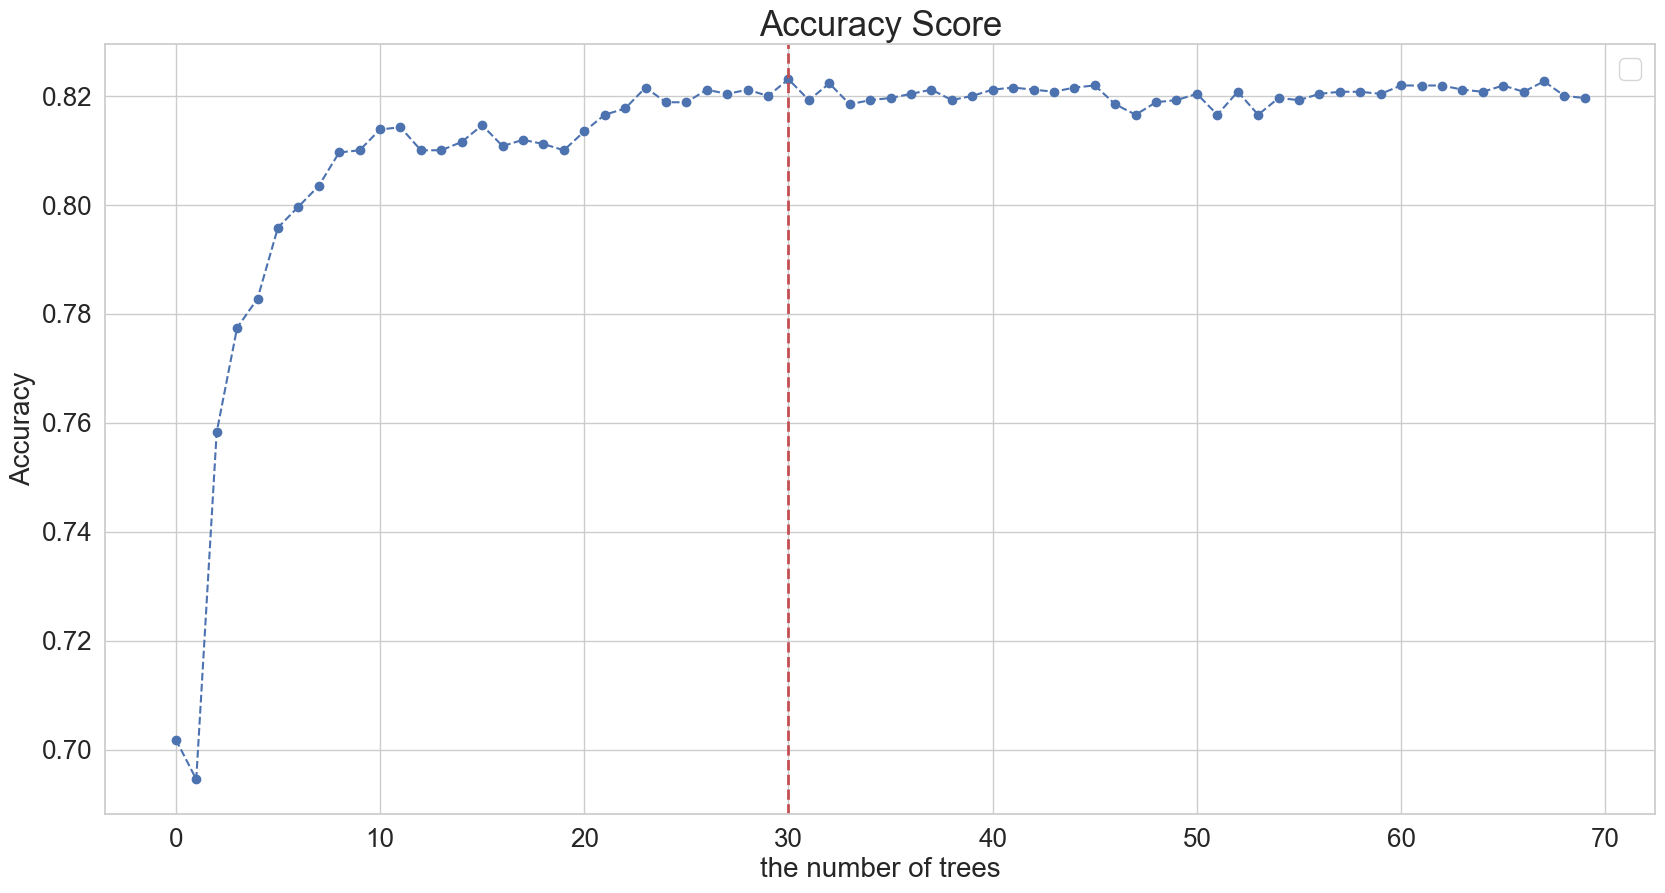

In [223]:
cv_scores = []
estimator_list =[i for i in range(70)]
for i in tqdm(range(70)):
    rfc = RandomForestClassifier(n_estimators=i+1,
                                 n_jobs=-1,
                                 random_state=0)
    score = cross_val_score(rfc, X_train, y_train, cv=10, scoring = 'accuracy').mean()
    cv_scores.append(score)

best_e = [estimator_list[i] for i in range(len(cv_scores)) if cv_scores[i] == np.max(cv_scores)]
plt.figure(figsize=(20,10))
plt.legend(["Cross validation scores"], fontsize=20)
plt.plot(estimator_list,cv_scores, marker='o', linestyle='dashed')
plt.xlabel("the number of trees", fontsize=20 )
plt.ylabel("Accuracy", fontsize=20)
plt.title("Accuracy Score", fontsize=25)
plt.axvline(best_e[0], color='r', linestyle='--', linewidth=2)
#수직으로 선을 그어어줘라!
plt.show()

In [224]:
print(f"최적의 tree개수:{(cv_scores.index(max(cv_scores)))+1}")
print("\n")  
print("Train set에 대한 성능 (10 fold cross validation)")  
print(f"정확도:{max(cv_scores):0.4f}")  

최적의 tree개수:31


Train set에 대한 성능 (10 fold cross validation)
정확도:0.8231


### 조금더 상승했다!

In [225]:
rfc = RandomForestClassifier(n_estimators= (cv_scores.index(max(cv_scores)))+1,n_jobs=-1,random_state=0)
param_grid = {
    'max_depth': [10,14,18,22],
    'max_leaf_nodes': [100,200,300,400,500],
    'criterion':['entropy'],
    'max_features':['sqrt']
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=10, verbose=1 ,n_jobs=-1)
CV_rfc.fit(X_train, y_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


GridSearchCV(cv=10,
             estimator=RandomForestClassifier(n_estimators=31, n_jobs=-1,
                                              random_state=0),
             n_jobs=-1,
             param_grid={'criterion': ['entropy'],
                         'max_depth': [10, 14, 18, 22],
                         'max_features': ['sqrt'],
                         'max_leaf_nodes': [100, 200, 300, 400, 500]},
             verbose=1)

In [226]:
# 최적의 하이퍼 파라미터 셋
CV_rfc.best_params_

{'criterion': 'entropy',
 'max_depth': 22,
 'max_features': 'sqrt',
 'max_leaf_nodes': 400}

In [227]:
result_table = pd.DataFrame(CV_rfc.cv_results_)
result_table = result_table.sort_values(by='mean_test_score', ascending=False)
print(result_table[['params', 'mean_test_score']])

                                               params  mean_test_score
19  {'criterion': 'entropy', 'max_depth': 22, 'max...         0.826932
18  {'criterion': 'entropy', 'max_depth': 22, 'max...         0.826932
17  {'criterion': 'entropy', 'max_depth': 22, 'max...         0.826927
13  {'criterion': 'entropy', 'max_depth': 18, 'max...         0.823114
14  {'criterion': 'entropy', 'max_depth': 18, 'max...         0.823114
6   {'criterion': 'entropy', 'max_depth': 14, 'max...         0.821944
12  {'criterion': 'entropy', 'max_depth': 18, 'max...         0.820809
7   {'criterion': 'entropy', 'max_depth': 14, 'max...         0.818490
8   {'criterion': 'entropy', 'max_depth': 14, 'max...         0.818490
9   {'criterion': 'entropy', 'max_depth': 14, 'max...         0.818490
16  {'criterion': 'entropy', 'max_depth': 22, 'max...         0.817731
11  {'criterion': 'entropy', 'max_depth': 18, 'max...         0.816581
2   {'criterion': 'entropy', 'max_depth': 10, 'max...         0.803914
3   {'

In [228]:
best_rfc = CV_rfc.best_estimator_
best_rfc.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=22, max_leaf_nodes=400,
                       n_estimators=31, n_jobs=-1, random_state=0)

In [229]:
# Train set에 대한 성능
y_pred = best_rfc.predict(X_train)
acc = accuracy_score(y_true = y_train, y_pred =y_pred)
print("Train set에 대한 성능")  
print(f"정확도:{acc:0.4f}")  

# Test set에 대한 성능
y_pred = best_rfc.predict(X_test)
acc = accuracy_score(y_true = y_test, y_pred =y_pred)
print("\n")  
print("Test set에 대한 성능")  
print(f"정확도:{acc:0.4f}")  

Train set에 대한 성능
정확도:0.9996


Test set에 대한 성능
정확도:0.8313


### 조금더 상승했다!

In [230]:
recall = recall_score(y_true=y_test, y_pred=y_pred, pos_label='DOWN', average=None)  # 다중 클래스에서는 average를 None으로 설정
precision = precision_score(y_true=y_test, y_pred=y_pred, average=None)  # 다중 클래스에서는 average를 None으로 설정

# 평가 메트릭스의 각 클래스에 대한 결과를 출력
for label, rec, prec in zip(['DOWN','UP'], recall, precision):
    print(f"클래스 {label}: 민감도 = {rec:.4f}, 정밀도 = {prec:.4f}")


클래스 DOWN: 민감도 = 0.8647, 정밀도 = 0.8689
클래스 UP: 민감도 = 0.7901, 정밀도 = 0.7931


C:\Users\siim2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1561: UserWarning: Note that pos_label (set to 'DOWN') is ignored when average != 'binary' (got None). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


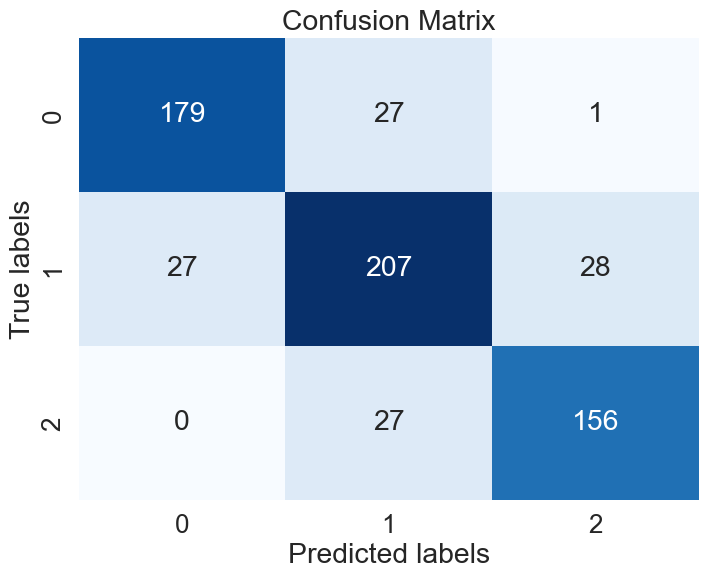

In [231]:
# 예측값 생성
y_pred = best_rfc.predict(X_test)

# 혼동 행렬 생성
cm = confusion_matrix(y_test, y_pred)

# 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap=plt.cm.Blues, fmt='d', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

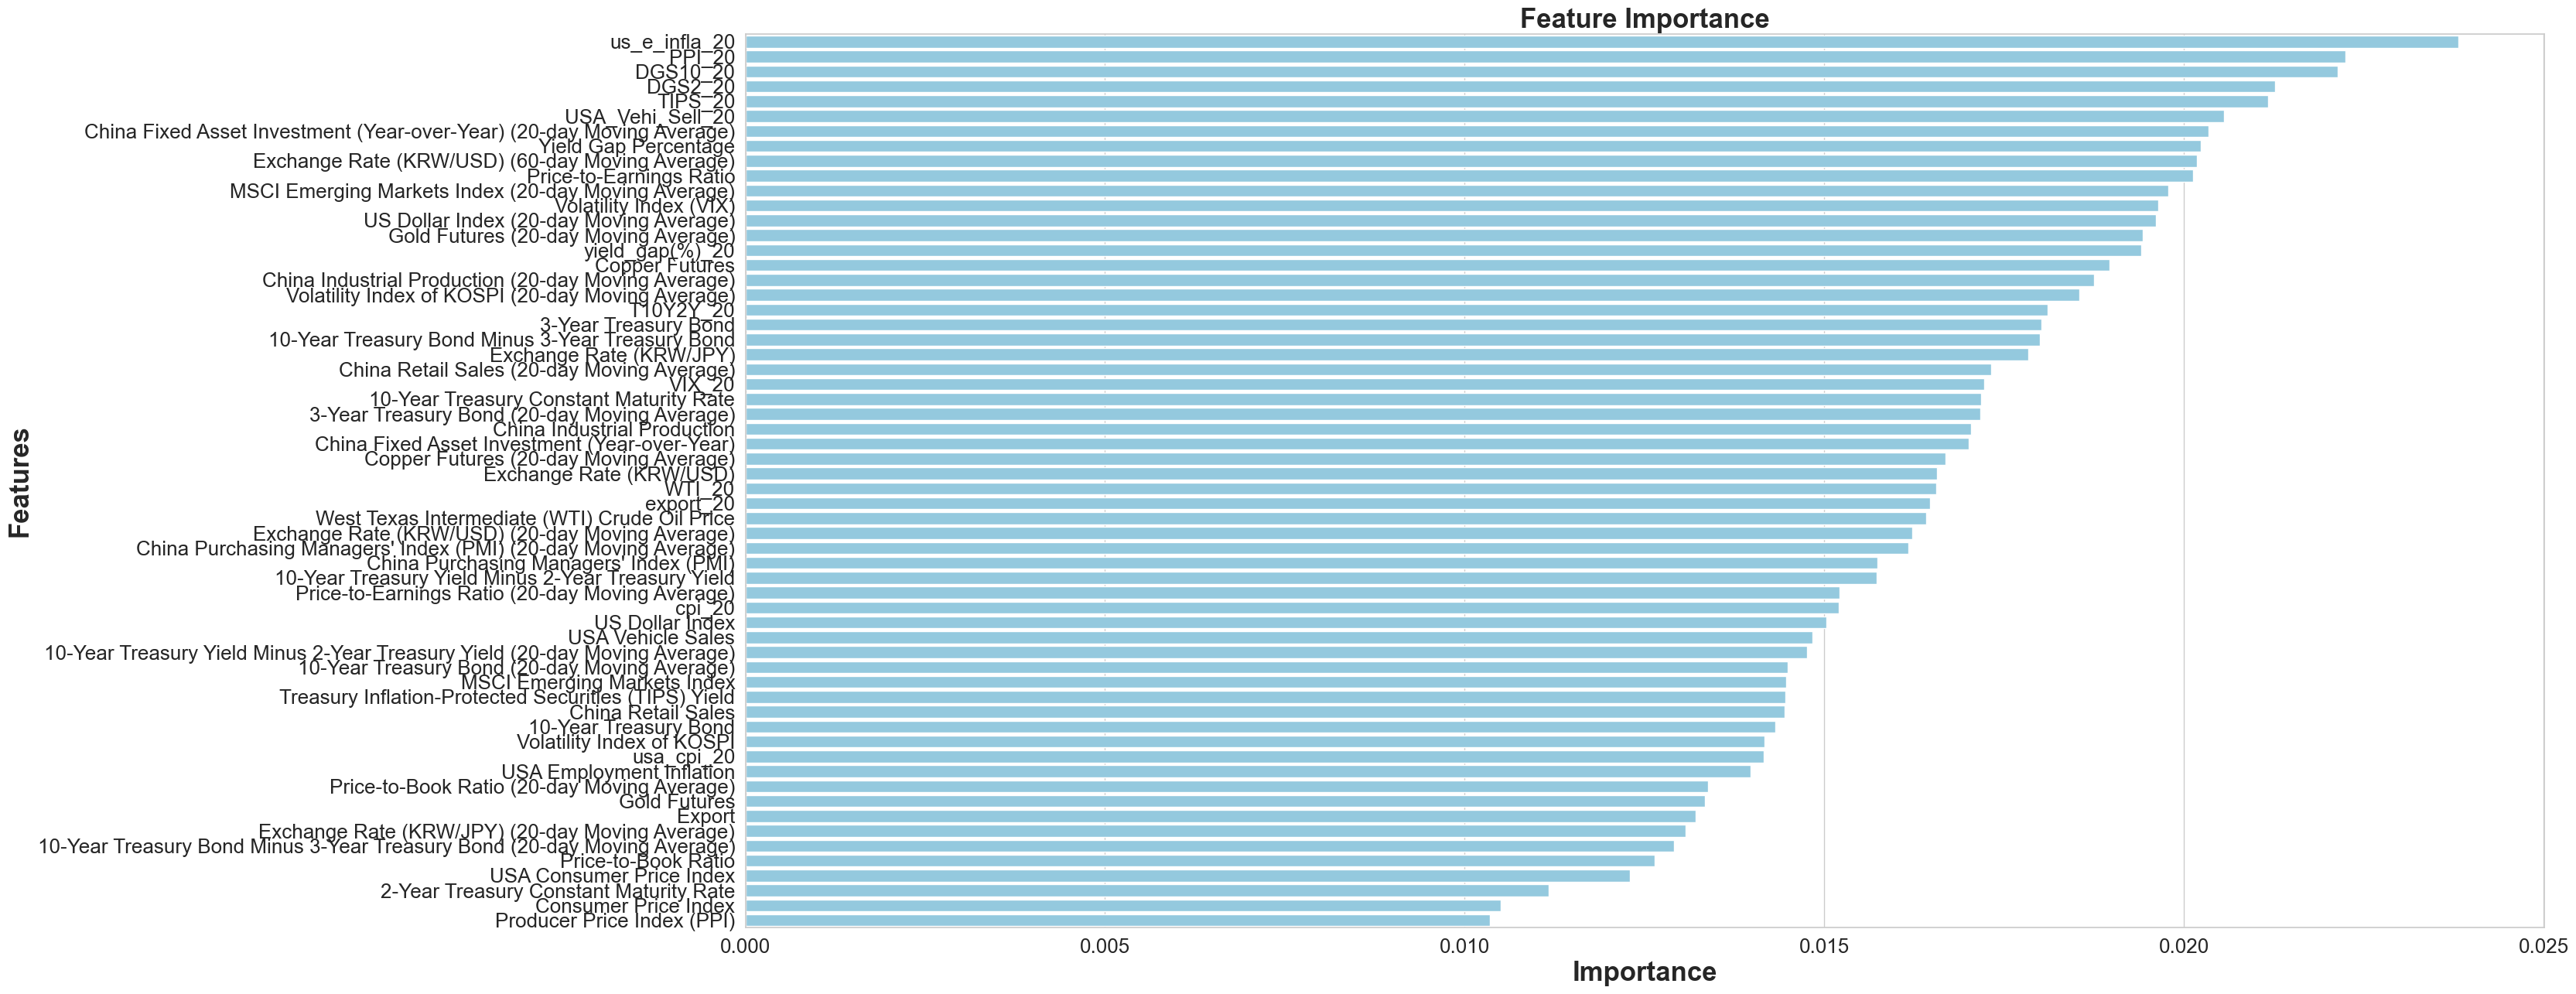

None

,Features,Gini-Importance
0,us_e_infla_20,0.023813
1,PPI_20,0.022249
2,DGS10_20,0.022133
3,DGS2_20,0.021263
4,TIPS_20,0.021166
5,USA_Vehi_Sell_20,0.020557
6,China Fixed Asset Investment (Year-over-Year) ...,0.020341
7,Yield Gap Percentage,0.020234
8,Exchange Rate (KRW/USD) (60-day Moving Average),0.020177
9,Price-to-Earnings Ratio,0.020131


In [232]:
feats = {}
for feature, importance in zip(X, best_rfc.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance', fontsize=25, weight = 'bold')
display(plt.show())
display(importances)

### 너무 많다.. 10개로


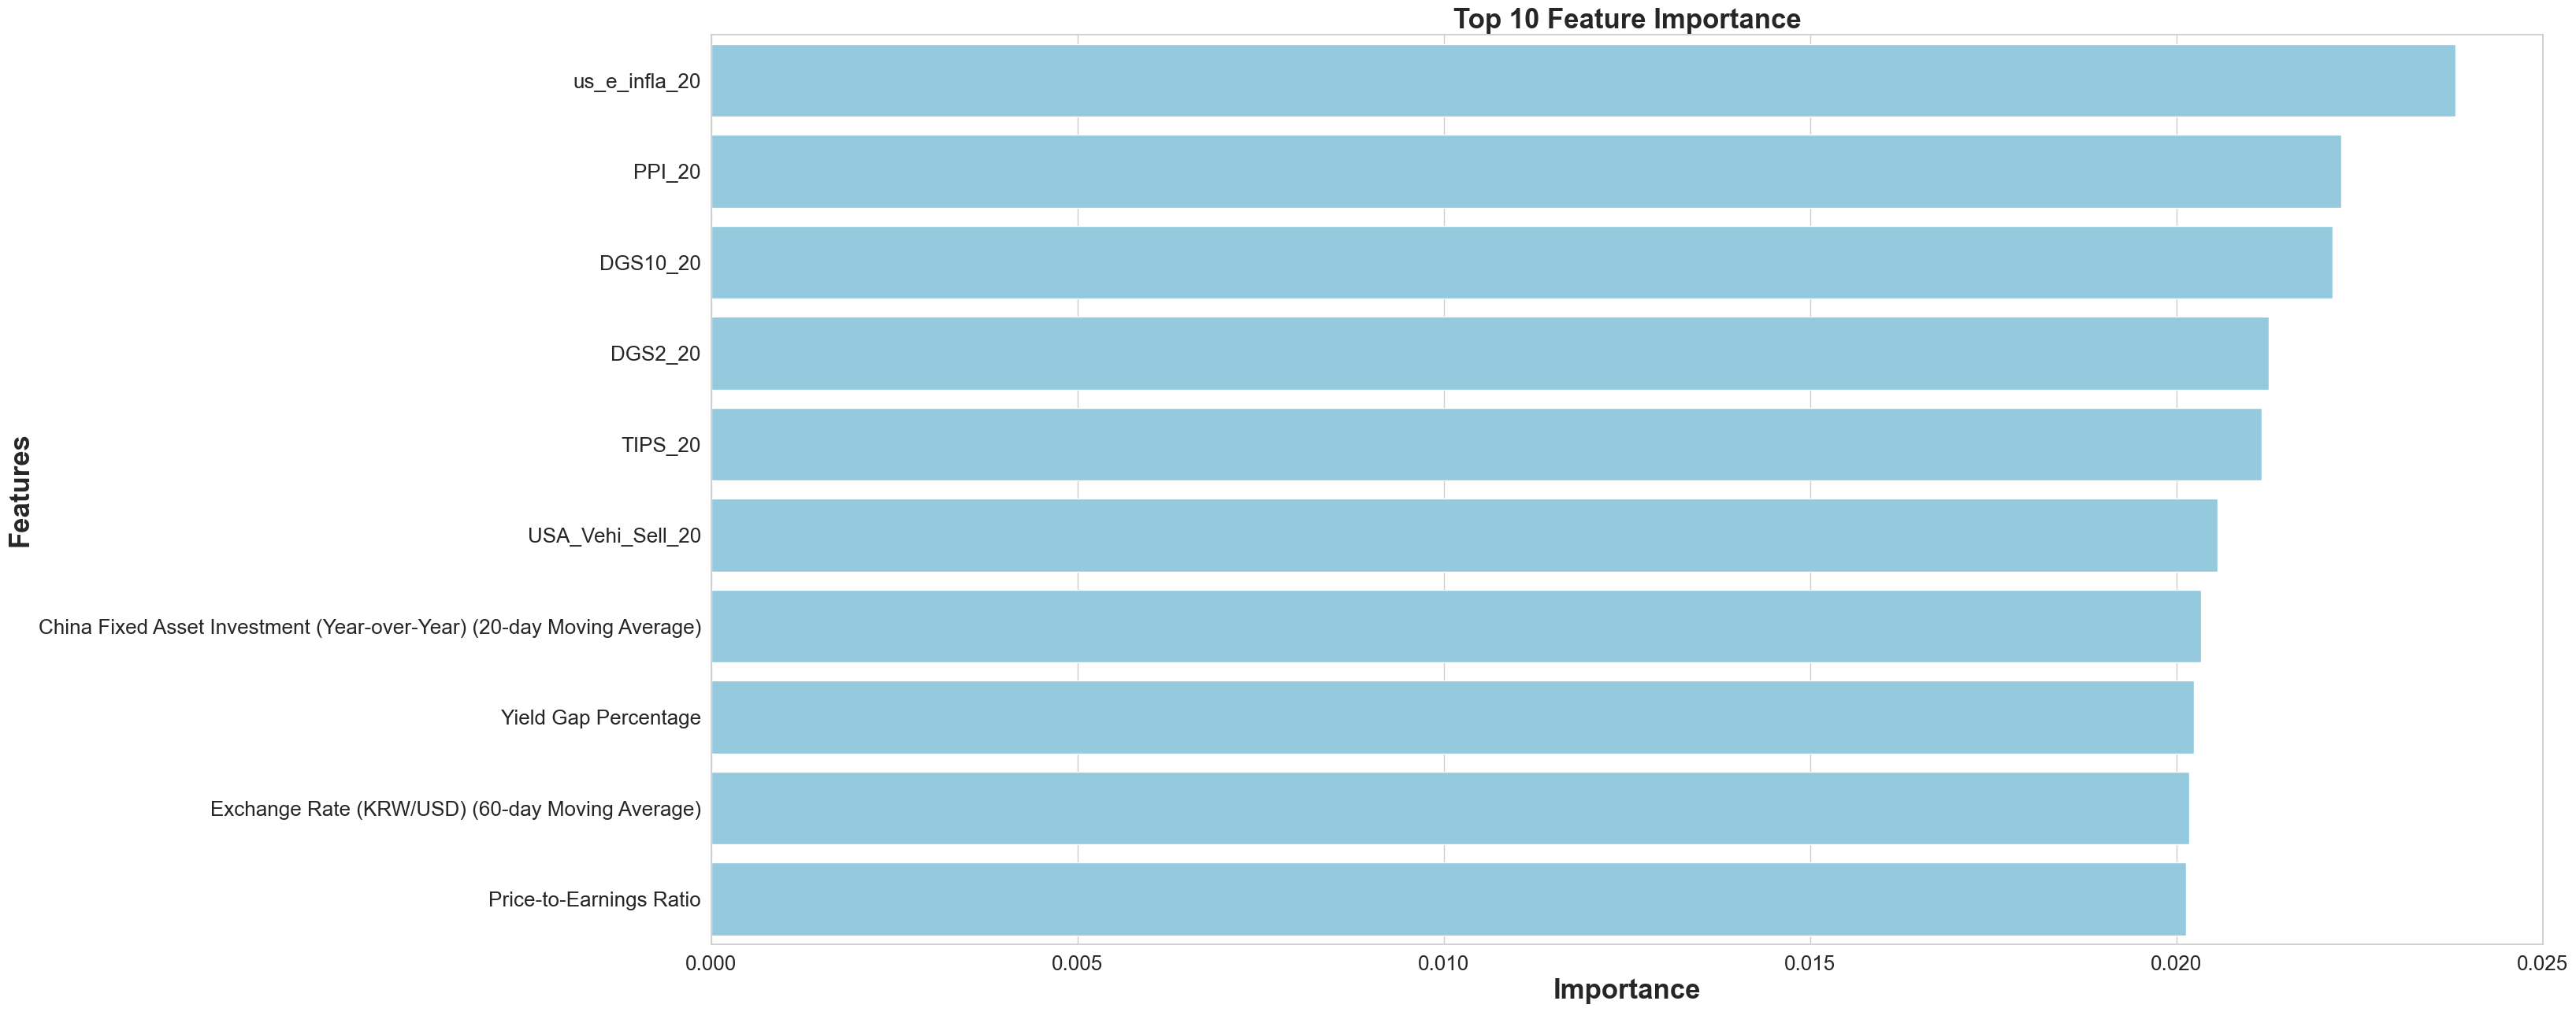

,Features,Gini-Importance
0,us_e_infla_20,0.023813
1,PPI_20,0.022249
2,DGS10_20,0.022133
3,DGS2_20,0.021263
4,TIPS_20,0.021166
5,USA_Vehi_Sell_20,0.020557
6,China Fixed Asset Investment (Year-over-Year) ...,0.020341
7,Yield Gap Percentage,0.020234
8,Exchange Rate (KRW/USD) (60-day Moving Average),0.020177
9,Price-to-Earnings Ratio,0.020131


In [233]:
feats = {}
for feature, importance in zip(X, best_rfc.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
top_10_importances = importances.head(10)  # 상위 10개만 선택

sns.set(font_scale=1.7)
sns.set(style="whitegrid", color_codes=True, font_scale=1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30, 15)
sns.barplot(x=top_10_importances['Gini-Importance'], y=top_10_importances['Features'], data=top_10_importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight='bold')
plt.ylabel('Features', fontsize=25, weight='bold')
plt.title('Top 10 Feature Importance', fontsize=25, weight='bold')
plt.show()

display(top_10_importances)


### 생각보다 자동차지수와 중국 지표 금 구리 이런게 영향을 많이 미치는구마잉!

In [240]:
# 6. 최종 모델 학습
best_rfc.fit(X_train, y_train) 
sheet_names = df.sheet_names

print("\n<AI model: machine learning done %s >" % sheet_names) 
print("accuracy_score of train data(0.8 of sample): ", best_rfc.score(X_train, y_train))
print("\n")
print("accuracy_score of test data(0.2 of sample): ", best_rfc.score(X_test, y_test)) 
y_test_pred = best_rfc.predict(X_test) 
print("\n")
print("accuracy_score of test data: ", mt.accuracy_score(y_test, y_test_pred)) 
# accuracy_score of test data(0.2 of sample):  0.823469387755102
# accuracy_score of test data:  0.823469387755102 test_size 0.3 으로 했을때
#accuracy_score of test data(0.2 of sample):  0.8192955589586524 test_size 0.2 으로 했을때

AttributeError: 'DataFrame' object has no attribute 'sheet_names'

In [235]:
# 10. backtesting용 과거의 예측데이터 생성
y_prediction = best_rfc.predict(X) 
y_pred = pd.Series(y_prediction, index=y.index) 


C:\Users\siim2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [236]:
# 11. 모델 저장
joblib.dump(best_rfc, "auto_model.pkl")
print("\n< AI model: save >")


< AI model: save >
